# Satellites Characterization
** EE-558, A Network Tour of Data Science ** <br>
** Lucas Gauchoux, Laurier Loiselle, Antoine Weber **

# 0. Abstract

# 1. Imports, global names and helper functions

In [13]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from pygsp import graphs, filters, plotting
from numpy import pi
import ephem
from tqdm import tqdm
import reverse_geocoder as rg
from collections import Counter
import networkx as nx
from multiprocessing import Pool
from scipy import sparse, stats, spatial, linalg
from pygsp import graphs, filters, plotting
from mpl_toolkits.basemap import Basemap
import sklearn
import itertools
import matplotlib as mpl
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
plt.rcParams['figure.figsize'] = (17, 5)

In [2]:
def read_tle(tle_file):
    tle = open(tle_file)
    lines = tle.readlines()
    return lines

In [3]:
def compute_tle_informations(lines):
    numb_element = len(lines)
    names = []
    long = []
    lat = []
    elevation_km = []
    for i in range(0,numb_element-1,3):
        temp = ephem.readtle(lines[i], lines[i+1], lines[i+2])
        temp.compute('2017/10/12')
        try:
            long.append(temp.sublong*180/pi)
            lat.append(temp.sublat*180/pi)
            elevation_km.append(temp.elevation/1000)
            names.append(temp.name[2:])
        except:
            print('Index number {} is not compatible to perform computation' .format(i))
    return names,long,lat,elevation_km

In [4]:
def satellite_orbit(name):
    orbit_point = []
    line_1, line_2 = dict_tle[name]
    period = int(sioi[sioi.OBJECT_NAME == name].PERIOD.values[0])
    delta_t = int(period*60/nb_point)
    delta_t = timedelta(seconds = delta_t)
    time = datetime(2017,10,12)
    l1, l2 = dict_tle[name]
    temp = ephem.readtle(name, l1, l2)
    for i in range(0,200):
        time = time + delta_t
        temp.compute(time)
        try:
            lat = temp.sublat*180/pi
            long = temp.sublong*180/pi
            orbit_point.append((lat,long))
        except:
            print("ERROR")
    return orbit_point

In [5]:
def compute_grids(res):
    orbit_grids= []
    vertical_offset =90
    horizontal_offset = 180
    shape = (180,360)
    coverage_width = range(-7, 7)
    for stats in res:
        grid = np.zeros(shape)
        for lat, long in stats:
            lat = round(lat) + vertical_offset
            long = round(long) + horizontal_offset
            for i in coverage_width:
                for j in coverage_width:
                    grid[(lat+i)%shape[0]][(long+j)%shape[1]] = 1
        orbit_grids.append(grid)
    return orbit_grids

In [6]:
def plot_map(data_final,labels1=None,label_value=None):
    plt.figure(figsize=(20,10))
    eq_map = Basemap(projection='robin', resolution = 'l', area_thresh = 1000.0,
                  lat_0=0,lon_0=0)
    eq_map.drawcoastlines()
    eq_map.drawcountries()
    eq_map.bluemarble()
    eq_map.drawmapboundary()
    eq_map.drawmeridians(np.arange(0, 360, 30))
    eq_map.drawparallels(np.arange(-90, 90, 30))

    if labels1 is not None:
        long = data_final['Longitude [°]'].values[labels1==label_value]
        lat = data_final['Latitude [°]'].values[labels1==label_value]
    else:
        long = data_final['Longitude [°]'].values
        lat = data_final['Latitude [°]'].values
    lons,lats = eq_map(long,lat)
    eq_map.scatter(lons, lats, marker = 'o', color='y', zorder=1)
    plt.show()

In [7]:
def dbscan_func(G,epsilon,mn,labels=None,label_value=None):
    centers = [[1, 1], [-1, -1], [1, -1]]
    
    if labels is not None:
        X = G.coords[labels==label_value]
    else:
        X = G.coords
        
    X = StandardScaler().fit_transform(X)
    db = DBSCAN(eps= epsilon, min_samples = mn).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels1 = db.labels_

    n_clusters_ = len(set(labels1)) - (1 if -1 in labels1 else 0)
    unique_labels = set(labels1)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels1 == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    return labels1

In [8]:
def compute_weight(sat1,sat2):
    tot = np.logical_and(sat1,sat2)
    return np.sum(tot)

In [9]:
def compute_adja(orbit_grids):
    adja = np.zeros([len(orbit_grids),len(orbit_grids)])
    for n1,i1 in enumerate(orbit_grids):
        for n2,i2 in enumerate(orbit_grids[n1+1:]):
            adja[n1,n2+n1+1] = compute_weight(i1,i2)
    return adja + np.transpose(adja)

# 2. Data Acquisition

# 3. Data Exploration

In [11]:
lines_tot = read_tle('Dataset/satellite_tle_current.txt')
assert [lines_tot.count('\n') == 0]

names,long,lat,elevation_km = compute_tle_informations(lines_tot)
data = pd.DataFrame(np.transpose([names,long,lat,elevation_km]))
data.columns = ['OBJECT_NAME','Longitude [°]','Latitude [°]','Elevation [km]']

Index number 5361 is not compatible to perform computation
Index number 49563 is not compatible to perform computation


In [12]:
coord = list(zip(lat,long))
result = rg.search(coord)
countries = [temp['cc'] for temp in result]
data['Country'] = countries

Loading formatted geocoded file...


In [18]:
data.head()

,OBJECT_NAME,Longitude [°],Latitude [°],Elevation [km],Country
0,VANGUARD 1,-63.01315328238157,-26.65173623575367,950.1053125,AR
1,VANGUARD 2,33.607191075144456,-32.25819456312109,2825.77825,ZA
2,VANGUARD R/B,158.90670062542114,1.4622271746404283,746.4226875,FM
3,VANGUARD R/B,-117.00344908625789,12.395302654786787,2056.953375,MX
4,VANGUARD 3,-14.979412519707317,-30.811335100669776,3271.14,SH


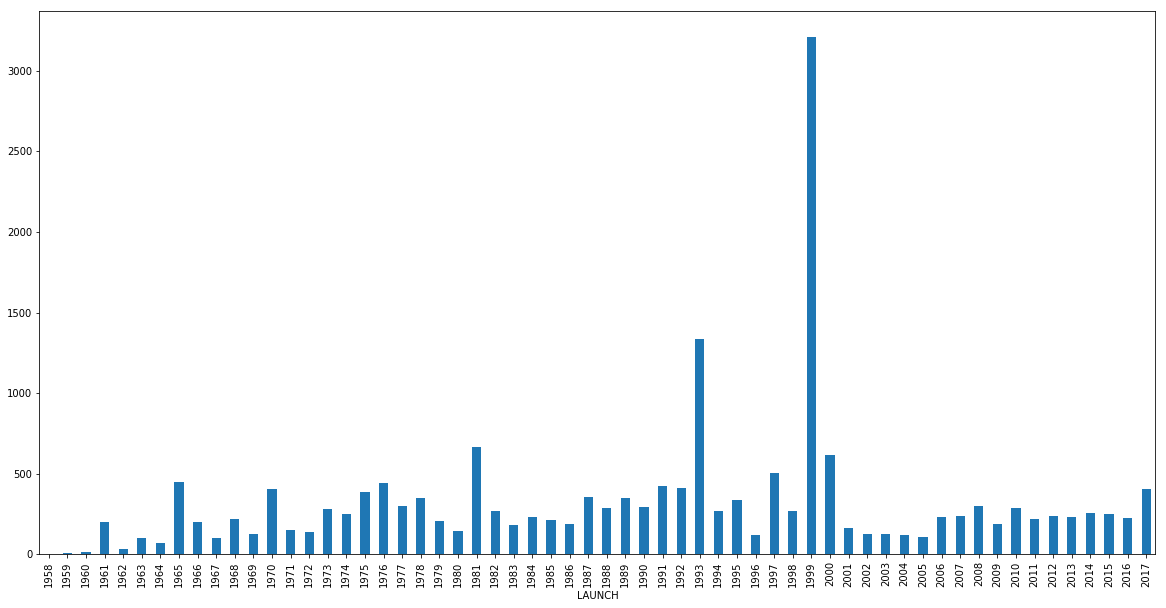

In [16]:
sioi = pd.read_csv("Dataset/satellites_in_orbit_info.csv")
sioi["LAUNCH"]= pd.to_datetime(sioi["LAUNCH"]).apply(lambda x: x.strftime('%Y'))
sioi.groupby("LAUNCH").size().plot(kind="bar", figsize=(20,10))
plt.show()